# Import Libraries/Packages & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [2]:
#load data
import os
attackdata = {}
os.chdir('C:/Final Year Project/idsattacks')
for i in os.listdir():
  if i != 'Benign.csv':
    attackdata[i] = pd.read_csv(i)
    attackdata[i].drop(['Dst Port', 'Timestamp', 'Flow Byts/s', 'Flow Pkts/s'], axis=1, inplace=True)


In [3]:
for i in attackdata:
    print(i, attackdata[i].shape)

Bot.csv (286191, 76)
Brute Force -Web.csv (611, 76)
Brute Force -XSS.csv (230, 76)
DDOS attack-HOIC.csv (686012, 76)
DDOS attack-LOIC-UDP.csv (1730, 76)
DDoS attacks-LOIC-HTTP.csv (576191, 76)
DoS attacks-GoldenEye.csv (41508, 76)
DoS attacks-Hulk.csv (461912, 76)
DoS attacks-SlowHTTPTest.csv (139890, 76)
DoS attacks-Slowloris.csv (10990, 76)
FTP-BruteForce.csv (193354, 76)
Infilteration.csv (160739, 76)
SQL Injection.csv (87, 76)
SSH-Bruteforce.csv (187589, 76)


In [4]:
bendata = pd.read_csv('C:/Final Year Project/idsattacks/Benign.csv')
#bendata.drop(['Unnamed: 0'], axis=1, inplace=True)
print(bendata.shape)

(2457307, 77)


In [5]:
#checking for unwanted columns
for i in attackdata:
  for j in ['Flow ID', 'Src IP', 'Src Port', 'Dst IP']:
    if j in attackdata[i].columns:
      print(i + " : " + j)
#attackdata[i].drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1, inplace=True)

In [6]:
for i in ['Unnamed: 0','Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Flow Byts/s', 'Flow Pkts/s']:
    if i in bendata.columns:
      print('bendata' + " : " + i)
bendata.drop(['Unnamed: 0'],axis=1,inplace=True)

bendata : Unnamed: 0


In [7]:
print(bendata.shape)

(2457307, 76)


In [8]:
#full data combined
fulldata = pd.DataFrame()
for i in attackdata:
    fulldata = pd.concat([fulldata, attackdata[i]], axis=0)
fulldata = pd.concat([fulldata, bendata], axis=0)
fulldata

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,16079,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
1,6,577,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
2,6,10279,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
3,6,457,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
4,6,10271,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457302,17,318,2,2,74.0,338.0,37.0,37.0,37.000000,0.000000,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2457303,17,1131,1,1,61.0,122.0,61.0,61.0,61.000000,0.000000,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2457304,17,1109,2,2,100.0,257.0,50.0,50.0,50.000000,0.000000,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2457305,17,866,2,2,74.0,338.0,37.0,37.0,37.000000,0.000000,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [9]:
#storing columns
fulldatacols = list(fulldata.columns)
fulldatacols.remove('Label')
fulldatacols

['Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd B

In [10]:
#fulldata labels
fulldatalabels = fulldata['Label']
fulldata.drop(['Label'], axis=1, inplace=True)

In [11]:
type(fulldatalabels)

pandas.core.series.Series

In [12]:
#scaling data
scaler = StandardScaler()
fulldata = scaler.fit_transform(fulldata)

In [13]:
fulldata = pd.DataFrame(fulldata, columns=fulldatacols)

In [14]:
fulldata

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.964372,-0.201171,-0.020599,0.223021,-0.018262,-0.010154,2.204220,-0.908249,2.487549,3.319083,...,-0.020755,0.276783,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
1,-0.964372,-0.202712,-0.020972,-0.158994,-0.022048,-0.019729,-0.482145,-0.908249,-0.932596,-0.330332,...,-0.021128,0.276783,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
2,-0.964372,-0.201747,-0.020599,0.223021,-0.018262,-0.010154,2.204220,-0.908249,2.487549,3.319083,...,-0.020755,0.276783,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
3,-0.964372,-0.202724,-0.020972,-0.158994,-0.022048,-0.019729,-0.482145,-0.908249,-0.932596,-0.330332,...,-0.021128,0.276783,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
4,-0.964372,-0.201748,-0.020599,0.223021,-0.018262,-0.010154,2.204220,-0.908249,2.487549,3.319083,...,-0.020755,0.276783,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204336,1.035242,-0.202738,-0.020972,0.032013,-0.021189,0.005360,-0.177251,0.805428,0.231932,-0.330332,...,-0.020755,-0.883533,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
5204337,1.035242,-0.202657,-0.021344,-0.063490,-0.021340,-0.010673,0.020519,1.917002,0.987302,-0.330332,...,-0.021128,-0.883533,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
5204338,1.035242,-0.202659,-0.020972,0.032013,-0.020887,-0.000653,-0.070126,1.407530,0.641091,-0.330332,...,-0.020755,-0.883533,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341
5204339,1.035242,-0.202683,-0.020972,0.032013,-0.021189,0.005360,-0.177251,0.805428,0.231932,-0.330332,...,-0.020755,-0.883533,-0.026816,-0.017742,-0.027417,-0.023571,-0.203215,-0.037831,-0.203415,-0.201341


In [15]:
fulldata.reset_index(inplace=True, drop=True)
fulldatalabels.reset_index(inplace=True, drop=True)

In [16]:
fulldata = pd.concat([fulldata, fulldatalabels], axis=1)
for i in attackdata:
    attackdata[i] = fulldata[fulldata['Label'] == i[:-4]]
bendata = fulldata[fulldata['Label'] == 'Benign']

In [17]:
del fulldata

In [18]:
attbenmixdata = {}
mixbendata = bendata[:int(bendata.shape[0]*0.05)]
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(i)
    attbenmixdata[i] = pd.concat([attackdata[i][:int(attackdata[i].shape[0]*0.7)], mixbendata], axis=0)
    attbenmixdata[i] = attbenmixdata[i].sample(frac=1).reset_index(drop=True)

Bot.csv
DDOS attack-HOIC.csv
DDoS attacks-LOIC-HTTP.csv
DoS attacks-Hulk.csv
DoS attacks-SlowHTTPTest.csv
FTP-BruteForce.csv
Infilteration.csv
SSH-Bruteforce.csv


In [19]:
for i in attbenmixdata:
  print(i + " : " + str(attbenmixdata[i].shape))
  print(attbenmixdata[i]['Label'].value_counts())

Bot.csv : (323198, 76)
Label
Bot       200333
Benign    122865
Name: count, dtype: int64
DDOS attack-HOIC.csv : (603073, 76)
Label
DDOS attack-HOIC    480208
Benign              122865
Name: count, dtype: int64
DDoS attacks-LOIC-HTTP.csv : (526198, 76)
Label
DDoS attacks-LOIC-HTTP    403333
Benign                    122865
Name: count, dtype: int64
DoS attacks-Hulk.csv : (446203, 76)
Label
DoS attacks-Hulk    323338
Benign              122865
Name: count, dtype: int64
DoS attacks-SlowHTTPTest.csv : (220788, 76)
Label
Benign                      122865
DoS attacks-SlowHTTPTest     97923
Name: count, dtype: int64
FTP-BruteForce.csv : (258212, 76)
Label
FTP-BruteForce    135347
Benign            122865
Name: count, dtype: int64
Infilteration.csv : (235382, 76)
Label
Benign           122865
Infilteration    112517
Name: count, dtype: int64
SSH-Bruteforce.csv : (254177, 76)
Label
SSH-Bruteforce    131312
Benign            122865
Name: count, dtype: int64


In [20]:
attbenmixdatalabels = {}
for i in attbenmixdata:
  attbenmixdatalabels[i] = attbenmixdata[i]['Label']
  attbenmixdata[i].drop(['Label'], axis=1, inplace=True)

In [21]:
#find minimum length for selecting equal number of samples from each class
set_len = []
not_set_len = []
for i in attackdata:
    if attackdata[i].shape[0] > 100000:
        set_len.append(attackdata[i].shape[0])
    else:
        not_set_len.append(attackdata[i].shape[0])
set_len = min(set_len)
not_set_len = min(not_set_len)

In [22]:
#combine all attack data and get equal number of data from each attack 
selectedattackbenmix = pd.DataFrame()
notselectedattackbenmix = pd.DataFrame()
for i in attackdata:
    if attackdata[i].shape[0] > 100000:
        selectedattackbenmix = pd.concat([selectedattackbenmix, attackdata[i][:set_len]], axis=0)
    else:
        notselectedattackbenmix = pd.concat([notselectedattackbenmix, attackdata[i][:not_set_len]], axis=0)

In [23]:
#combine selected and not selected attack data with benign data
selectedattackbenmix = pd.concat([selectedattackbenmix, bendata[:set_len]], axis=0)
notselectedattackbenmix = pd.concat([notselectedattackbenmix, bendata[:not_set_len]], axis=0)
print(selectedattackbenmix['Label'].value_counts())
print(notselectedattackbenmix['Label'].value_counts())

Label
Bot                         139890
DDOS attack-HOIC            139890
DDoS attacks-LOIC-HTTP      139890
DoS attacks-Hulk            139890
DoS attacks-SlowHTTPTest    139890
FTP-BruteForce              139890
Infilteration               139890
SSH-Bruteforce              139890
Benign                      139890
Name: count, dtype: int64
Label
Brute Force -Web         87
Brute Force -XSS         87
DDOS attack-LOIC-UDP     87
DoS attacks-GoldenEye    87
DoS attacks-Slowloris    87
SQL Injection            87
Benign                   87
Name: count, dtype: int64


In [24]:
print('bendata' + " : " + str(bendata.shape))

bendata : (2457307, 76)


In [25]:
len(attackdata)

14

In [26]:
for i in attackdata:
  attackdata[i].drop(['Label'], axis=1, inplace=True)
bendata.drop(['Label'], axis=1, inplace=True)

In [27]:
#printing the shapes of the data
for i in attackdata:
  print(i + " : " + str(attackdata[i].shape))

Bot.csv : (286191, 75)
Brute Force -Web.csv : (611, 75)
Brute Force -XSS.csv : (230, 75)
DDOS attack-HOIC.csv : (686012, 75)
DDOS attack-LOIC-UDP.csv : (1730, 75)
DDoS attacks-LOIC-HTTP.csv : (576191, 75)
DoS attacks-GoldenEye.csv : (41508, 75)
DoS attacks-Hulk.csv : (461912, 75)
DoS attacks-SlowHTTPTest.csv : (139890, 75)
DoS attacks-Slowloris.csv : (10990, 75)
FTP-BruteForce.csv : (193354, 75)
Infilteration.csv : (160739, 75)
SQL Injection.csv : (87, 75)
SSH-Bruteforce.csv : (187589, 75)


In [28]:
for i in attackdata:
    attackdata[i] = attackdata[i].to_numpy()

In [29]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
test_loader = {}
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    train_loader[i] = torch.utils.data.DataLoader(attackdata[i][:int(attackdata[i].shape[0]*0.9)], batch_size = batch_size, shuffle=True)
    test_loader[i] = torch.utils.data.DataLoader(attackdata[i][int(attackdata[i].shape[0]*0.9):], batch_size = batch_size, shuffle=True)
    devices.append(i)

In [30]:
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(len(test_loader[i]))

224
536
451
361
110
152
126
147


In [31]:
bendata = bendata.to_numpy()

In [32]:
ben_loader = torch.utils.data.DataLoader(bendata[int(bendata.shape[0]*0.9):], batch_size = batch_size, shuffle=True)

In [33]:
for i in attbenmixdata:
    attbenmixdata[i] = attbenmixdata[i].to_numpy()

In [34]:
attbenmixdata_loader = {}
for i in attbenmixdata:
    attbenmixdata_loader[i] = torch.utils.data.DataLoader(attbenmixdata[i], batch_size = batch_size, shuffle=True)

In [35]:
selectedattackbenmix_labels = selectedattackbenmix['Label']
notselectedattackbenmix_labels = notselectedattackbenmix['Label']
selectedattackbenmix.drop(['Label'], axis=1, inplace=True)
notselectedattackbenmix.drop(['Label'], axis=1, inplace=True)

In [36]:
selectedattackbenmix = selectedattackbenmix.to_numpy()
notselectedattackbenmix = notselectedattackbenmix.to_numpy()

In [37]:
selectedattackbenmix_loader = torch.utils.data.DataLoader(selectedattackbenmix, batch_size = batch_size, shuffle=True)
notselectedattackbenmix_loader = torch.utils.data.DataLoader(notselectedattackbenmix, batch_size = batch_size, shuffle=True)

In [38]:
train_loader['Benign.csv'] = ben_loader

In [39]:
devices.append('Benign.csv')

In [40]:
len(train_loader)

9

In [41]:
len(devices)

9

In [42]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 10  #100      # Total number of communication rounds for the global model to train.
epochs = 50          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [43]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [44]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [45]:
# Deep Auto-encoder model

input_dim = 75
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        #self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc2 = nn.Linear(input_dim, 32)
        #self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        #self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 8)
        #self.bn4 = nn.BatchNorm1d(8)
        self.fc5 = nn.Linear(8, 8)
        #self.bn5 = nn.BatchNorm1d(8)
        self.fc6 = nn.Linear(8, 16)
        #self.bn6 = nn.BatchNorm1d(16)
        self.fc7 = nn.Linear(16, 32)
        #self.bn7 = nn.BatchNorm1d(32)
        self.fc8 = nn.Linear(32, input_dim)
        #self.bn8 = nn.BatchNorm1d(input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
        self.activation = nn.Tanh()

        # Initialize weights using He initialization with Tanh
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc5.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc6.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc7.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc8.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc9.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.activation(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        x = self.activation(x)
        x = self.fc4(x)
        #x = self.bn4(x)
        x = self.activation(x)
        x = self.fc5(x)
        #x = self.bn5(x)
        x = self.activation(x)
        x = self.fc6(x)
        #x = self.bn6(x)
        x = self.activation(x)
        x = self.fc7(x)
        #x = self.bn7(x)
        x = self.activation(x)
        x = self.fc8(x)
        #x = self.bn8(x)
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [46]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

# Training Federated Model

In [47]:

'''
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []
train_loss_per_client = [[] for i in range(num_clients)]
train_loss_benign = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    client_idx = list(range(num_clients))
    print('client_idx: ', client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected-1)): # num_selected-1 because last client is benign
        # print(i)
        client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        l = client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
        train_loss_per_client[i].append(l)
        loss += l
    train_loss_client.append(loss)

    #### benign client update ####
    for i in tqdm(range(1)):
        l = client_update(client_models[-1], opt[-1], train_loader[devices[client_idx[-1]]], epochs)
        train_loss_benign.append(l)


    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    attackclients = []
    for i in devices:
        if i != 'Benign.csv':
            attackclients.append(client_models[devices.index(i)])
    
    ### aggregate models ###
    server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    #print('global_loss: ', loss_retrain/num_selected)

time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))
'''

'\n# Train Client Model and Global Model\ntrain_loss_client = []\ntrain_loss_global = []\ntrain_loss_per_client = [[] for i in range(num_clients)]\ntrain_loss_benign = []\n\nstart_time = time.time()\n\nfor r in range(num_rounds): # total number of rounds\n\n    print(\'\nround: \', r+1)\n    # num_selected = random.choice(range(1,num_clients))\n    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train\n    client_idx = list(range(num_clients))\n    print(\'client_idx: \', client_idx)\n    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.\n    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]\n    #print(client_lens)\n\n\n    #### client update ####\n    loss = 0\n    for i in tqdm(range(num_selected-1)): # num_selected-1 because last client is benign\n        # print(i)\n        client_syn(client_models[i], global_model)\n 

In [48]:
'''
for i in range(len(train_loss_per_client)):
  print(train_loss_per_client[i])
'''

'\nfor i in range(len(train_loss_per_client)):\n  print(train_loss_per_client[i])\n'

In [49]:
'''
# save model
torch.save(global_model,'C:/Final Year Project/models/globalattackmodel.pt')
'''

"\n# save model\ntorch.save(global_model,'C:/Final Year Project/models/globalattackmodel.pt')\n"

In [50]:
'''
for i in range(len(devices)):
  torch.save(client_models[i],'C:/Final Year Project/models/clients/' + devices[i] + '.pt')
'''

"\nfor i in range(len(devices)):\n  torch.save(client_models[i],'C:/Final Year Project/models/clients/' + devices[i] + '.pt')\n"

In [51]:
def printperformance(model, losses, modelname):
    plt.plot(losses)
    plt.xlabel('number of rounds')
    plt.ylabel('loss')
    plt.ylim((0, 2.5))
    plt.grid()
    plt.title(modelname)
    plt.show()

In [52]:
'''
for i in range(len(devices)-1):
  printperformance(client_models[i], train_loss_per_client[i], devices[i])
'''

'\nfor i in range(len(devices)-1):\n  printperformance(client_models[i], train_loss_per_client[i], devices[i])\n'

In [53]:
'''
# print performance of benign client
printperformance(client_models[-1], train_loss_benign, devices[-1])
'''

'\n# print performance of benign client\nprintperformance(client_models[-1], train_loss_benign, devices[-1])\n'

In [54]:
'''
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()
'''

"\n# train_loss_global\nplt.plot(train_loss_global)\nplt.xlabel('number of rounds')\nplt.ylabel('loss')\nplt.ylim((0, 2.5))\nplt.grid()\nplt.title('Federated Model with FedAvg (use five devices to train)')\nplt.show()\n"

# Evaluation

In [55]:
client_models = []
for i in range(len(devices)):
  client_models.append(torch.load('C:/Final Year Project/models/clients/' + devices[i] + '.pt'))

In [56]:
from sklearn import metrics

In [57]:
def get_thresh(model, dataloader):

    model.eval()
    errs = []
    for batch in dataloader:
       for data in batch:
         mse = np.mean(np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2), axis=0)
         thresh = mse.mean() + mse.std()
         errs.append(thresh)
    thresh = sum(errs) / len(errs)
    return thresh

    #model.eval()
    #pred = global_model(tr_data).cpu().detach().numpy()
    #print(pred)
    #print(np.isnan(pred))
    #thresh = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
    #mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    #tr = np.sqrt(metrics.mean_squared_error(model(tr_data).cpu().detach().numpy(), tr_data.cpu().detach().numpy()))
    #tr = np.sqrt(mse)
    #return thresh
    
    
def quan_thresh(model, dataloader, quantile=0.9):

  model.eval()
  errs = []
  
  for batch in dataloader:
    
    mse = []
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2)
      mse.append(error)
    
    # Calculate threshold as quantile of errors 
    thresh = np.quantile(mse, quantile)  
    errs.append(thresh)
    
  return np.mean(errs)

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    prediction = []
    for i in mix_data:
      pred = model(i).cpu().detach().numpy()
      error = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
      if error > tr:
        prediction.append(1)
      else:
        prediction.append(0)

    mix_label_list = mix_label.tolist()

    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)

    conf = [[TP, FN],[FP, TN]]
    print(conf)
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']

    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [58]:
thresholds = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = train_loader[devices[i]]
    thresholds[devices[i]] = quan_thresh(model, dataloader)
print(thresholds)

{'Bot.csv': 1.2452535098663802, 'DDOS attack-HOIC.csv': 1.5985287667185737, 'DDoS attacks-LOIC-HTTP.csv': 4.116102695700449, 'DoS attacks-Hulk.csv': 1.230553867477061, 'DoS attacks-SlowHTTPTest.csv': 1.271297097448411, 'FTP-BruteForce.csv': 1.23847485533532, 'Infilteration.csv': 1.6612906269538108, 'SSH-Bruteforce.csv': 2.704632798643886, 'Benign.csv': 0.024658501755087277}


In [59]:
'''thresholds_test = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = test_loader[devices[i]]
    thresholds_test[devices[i]] = get_thresh(model, dataloader)
print(thresholds_test)'''

'thresholds_test = {}\nfor i in range(len(devices)):\n    model = client_models[i]\n    dataloader = test_loader[devices[i]]\n    thresholds_test[devices[i]] = get_thresh(model, dataloader)\nprint(thresholds_test)'

In [60]:
len(thresholds)

9

In [61]:
devices

['Bot.csv',
 'DDOS attack-HOIC.csv',
 'DDoS attacks-LOIC-HTTP.csv',
 'DoS attacks-Hulk.csv',
 'DoS attacks-SlowHTTPTest.csv',
 'FTP-BruteForce.csv',
 'Infilteration.csv',
 'SSH-Bruteforce.csv',
 'Benign.csv']

In [62]:
test_loader

{'Bot.csv': <torch.utils.data.dataloader.DataLoader at 0x23bb88009a0>,
 'DDOS attack-HOIC.csv': <torch.utils.data.dataloader.DataLoader at 0x23b91c3e6b0>,
 'DDoS attacks-LOIC-HTTP.csv': <torch.utils.data.dataloader.DataLoader at 0x23b91c3e470>,
 'DoS attacks-Hulk.csv': <torch.utils.data.dataloader.DataLoader at 0x23b91c3f7f0>,
 'DoS attacks-SlowHTTPTest.csv': <torch.utils.data.dataloader.DataLoader at 0x23b91c3fa00>,
 'FTP-BruteForce.csv': <torch.utils.data.dataloader.DataLoader at 0x23b91c3f820>,
 'Infilteration.csv': <torch.utils.data.dataloader.DataLoader at 0x23b92fc8700>,
 'SSH-Bruteforce.csv': <torch.utils.data.dataloader.DataLoader at 0x23b92fc8760>}

C:\Users\amenu4aie20110\AppData\Local\Temp\ipykernel_16984\3154254825.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


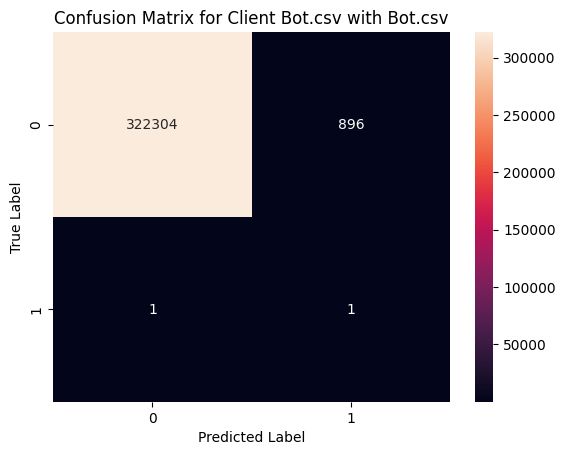

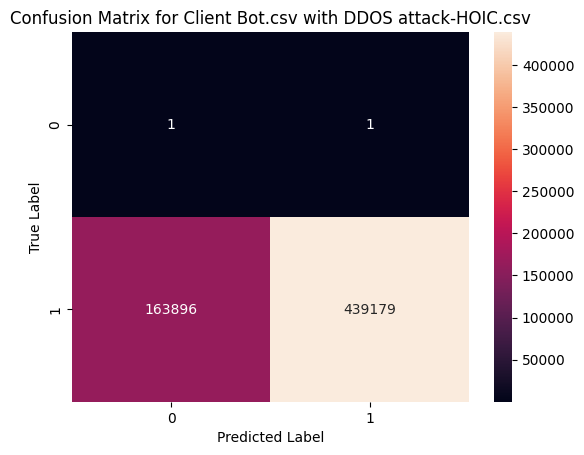

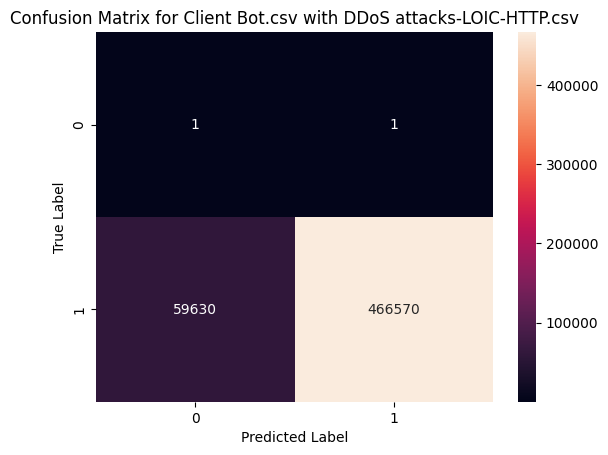

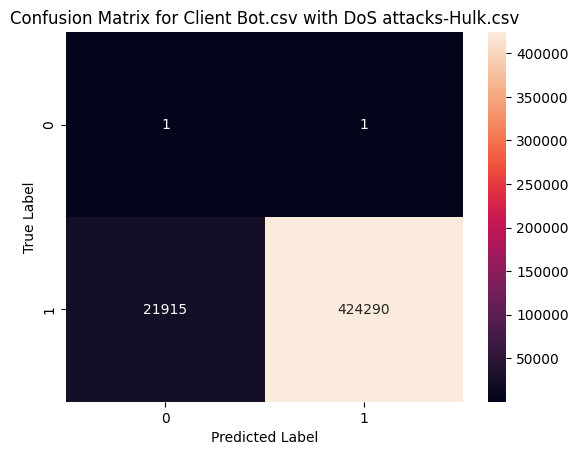

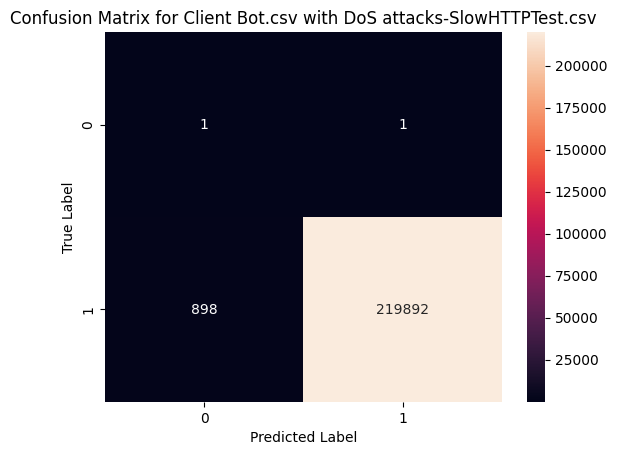

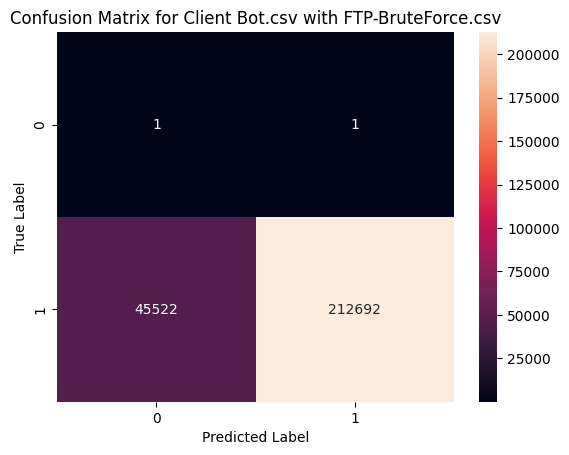

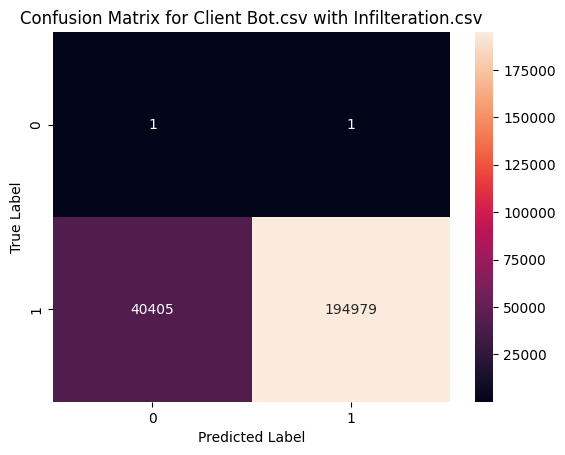

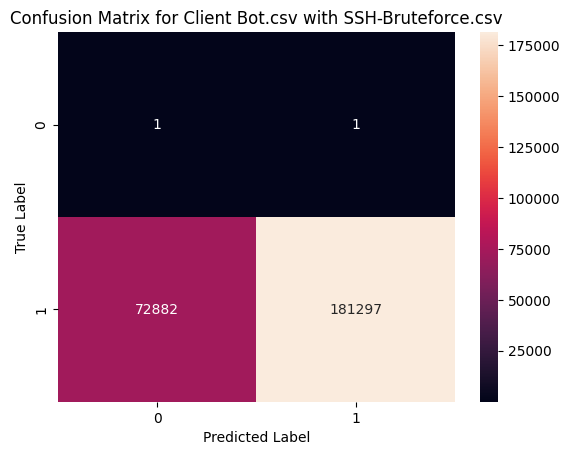

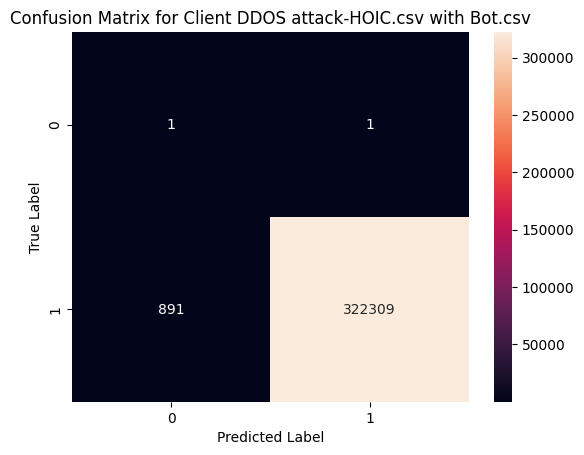

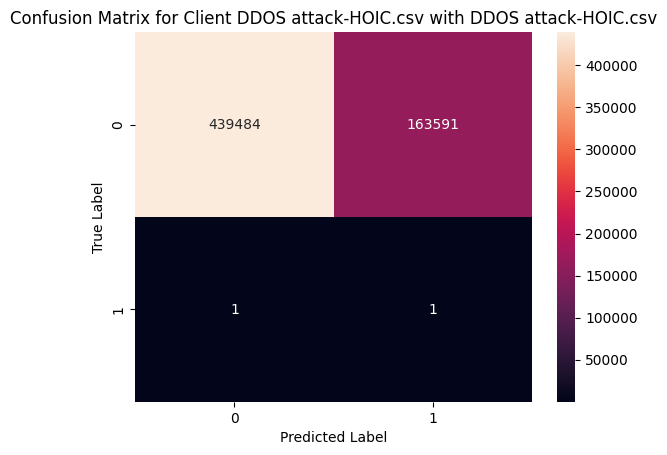

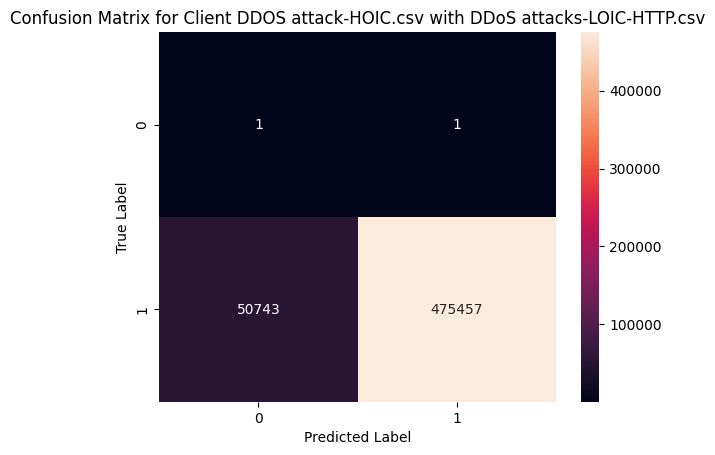

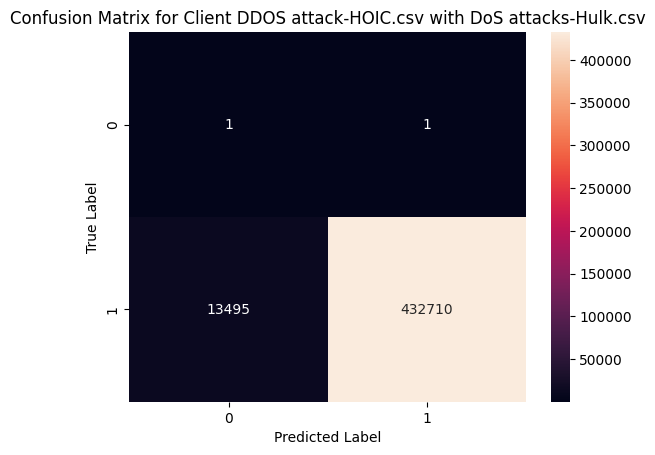

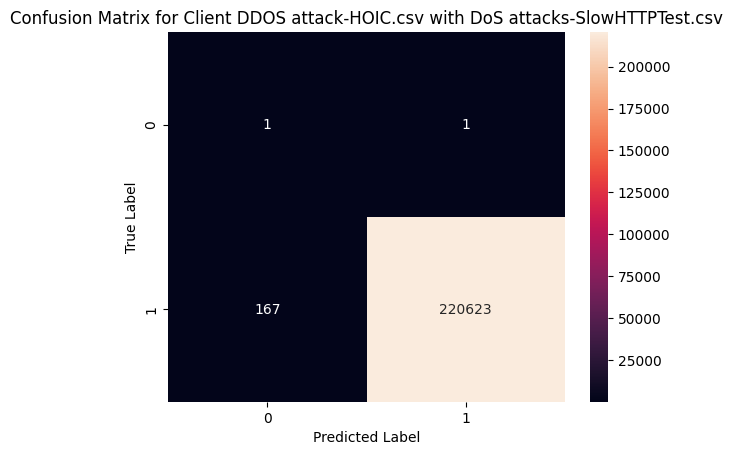

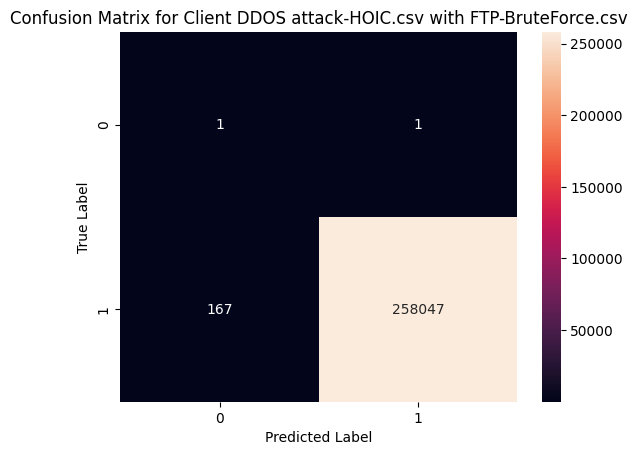

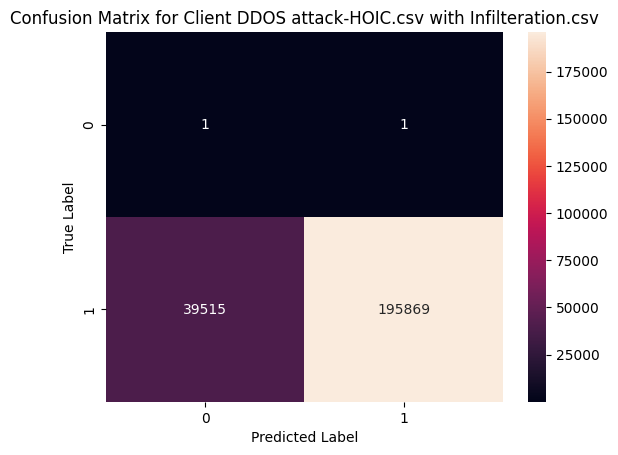

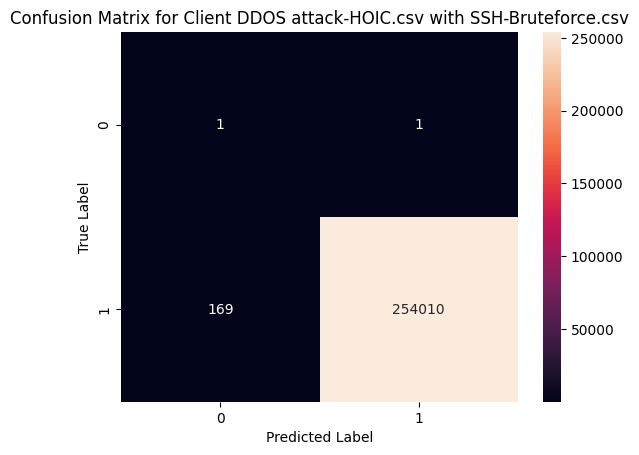

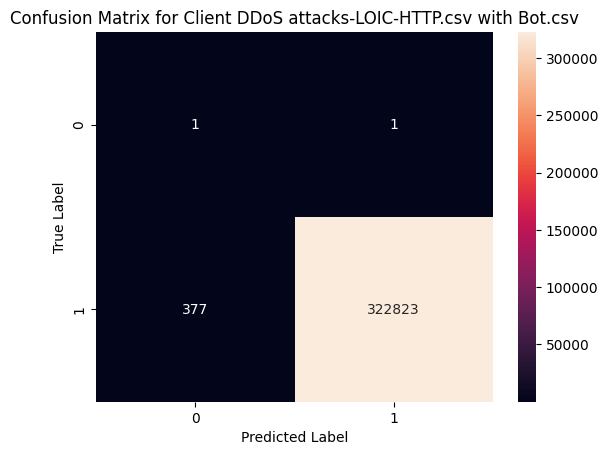

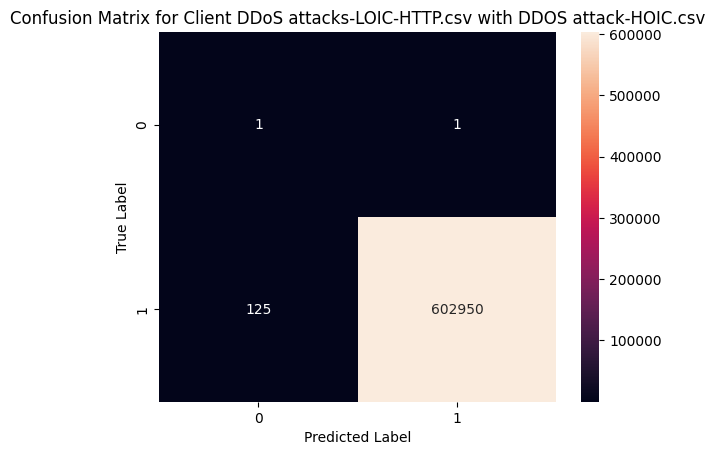

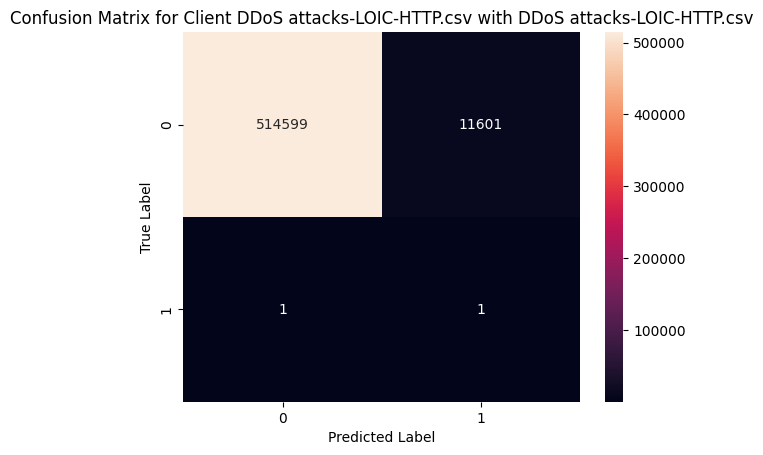

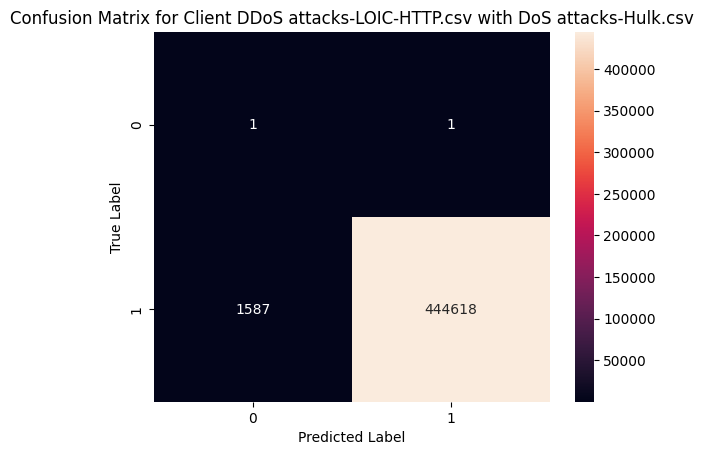

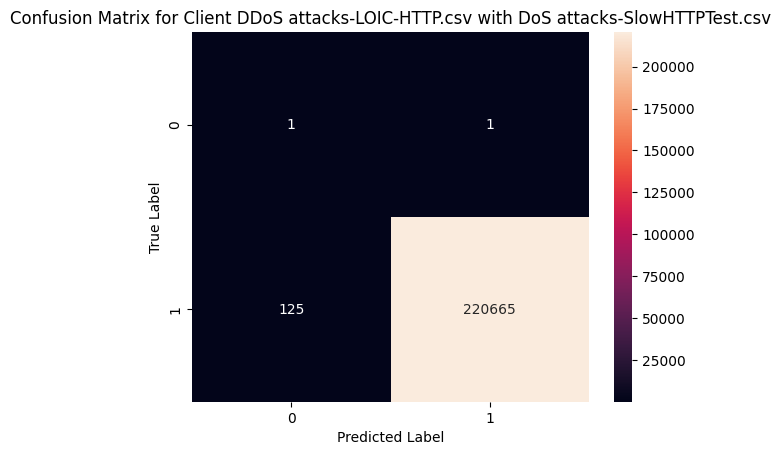

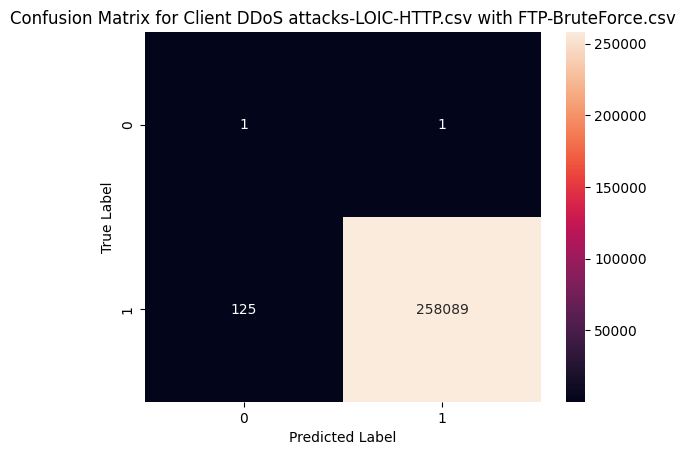

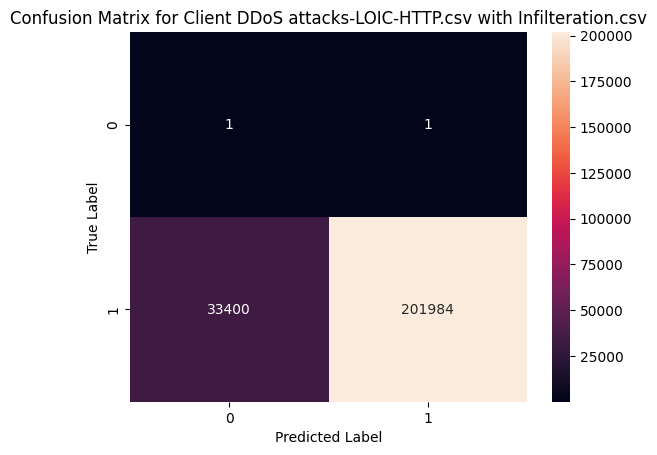

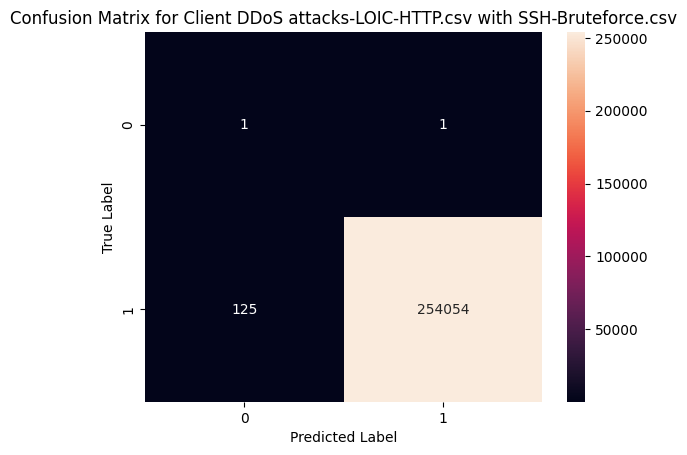

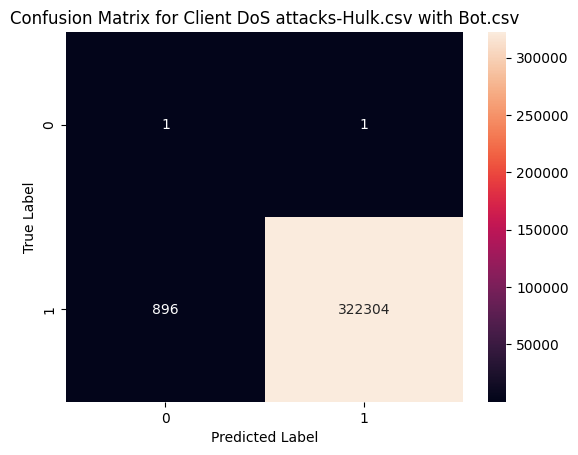

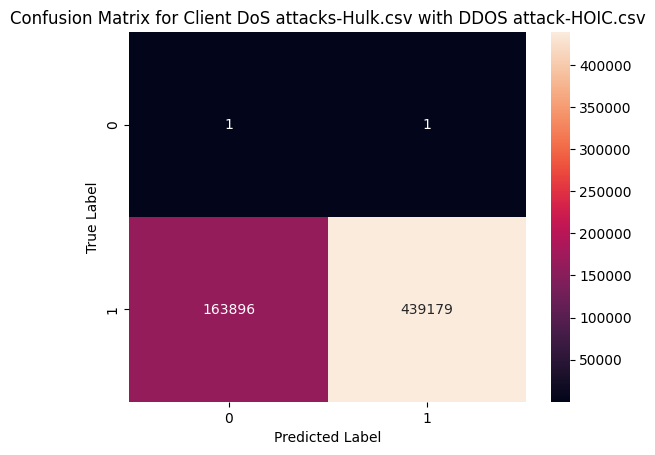

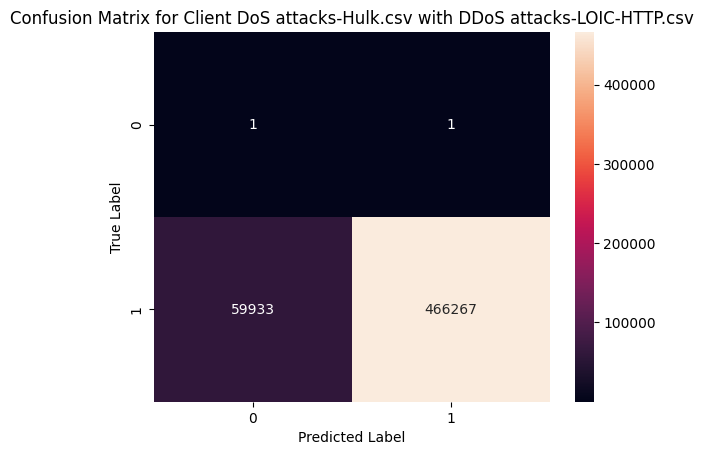

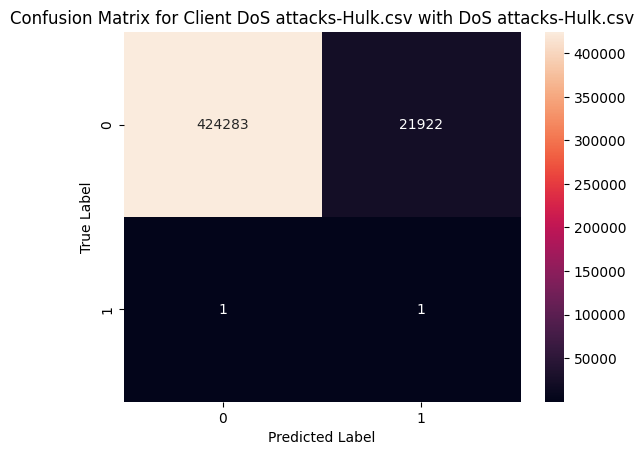

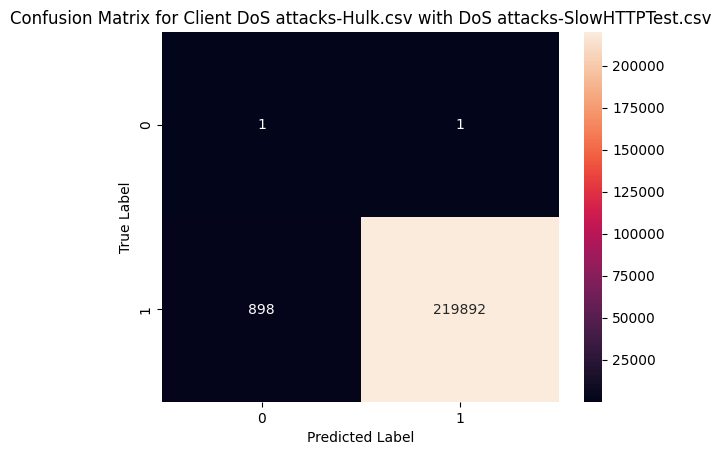

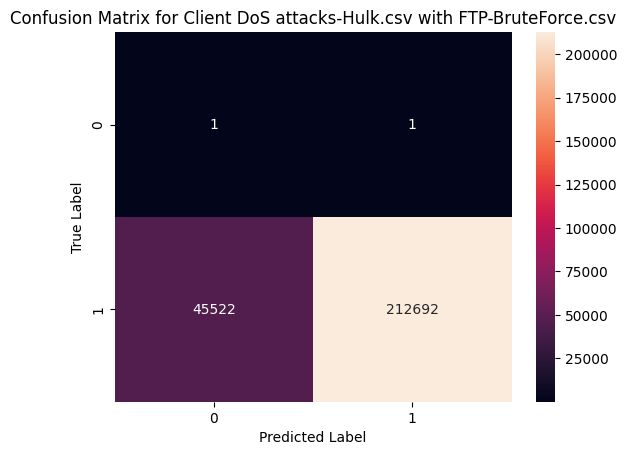

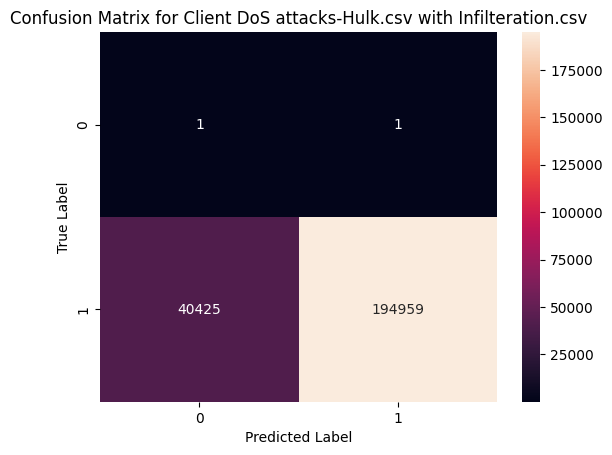

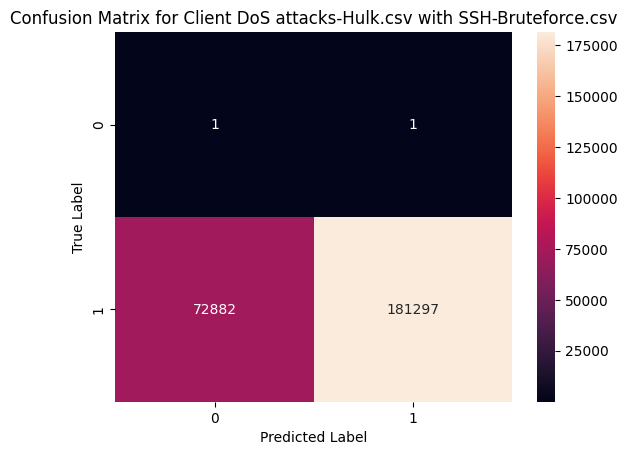

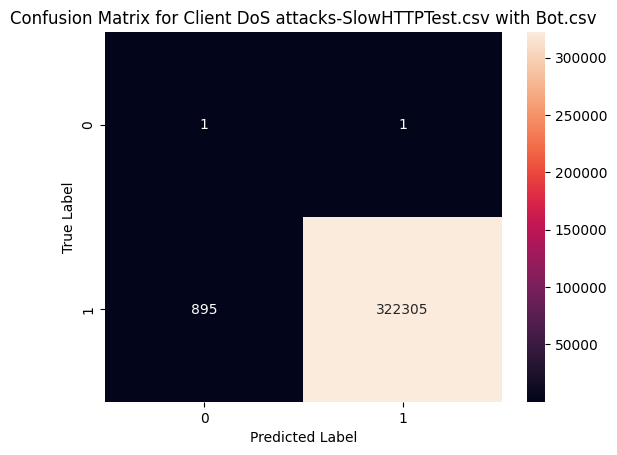

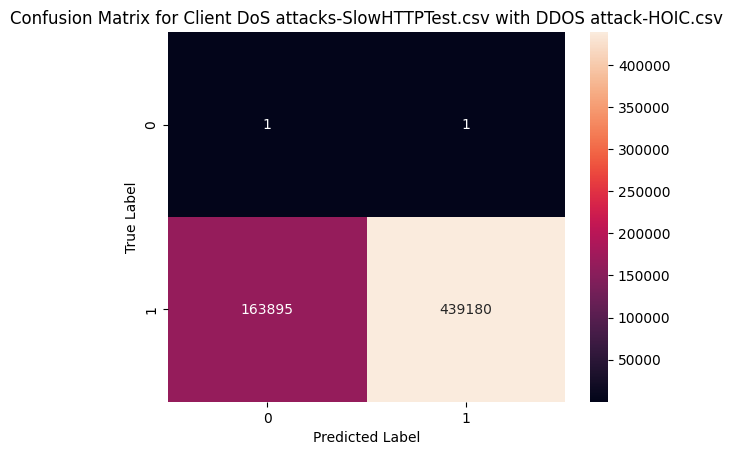

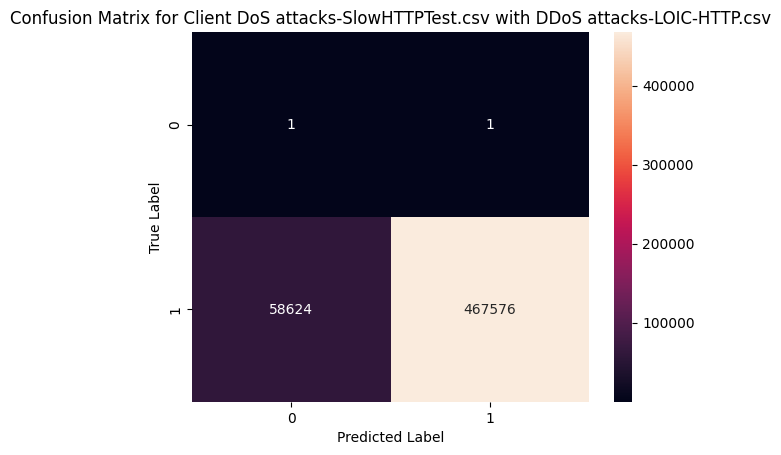

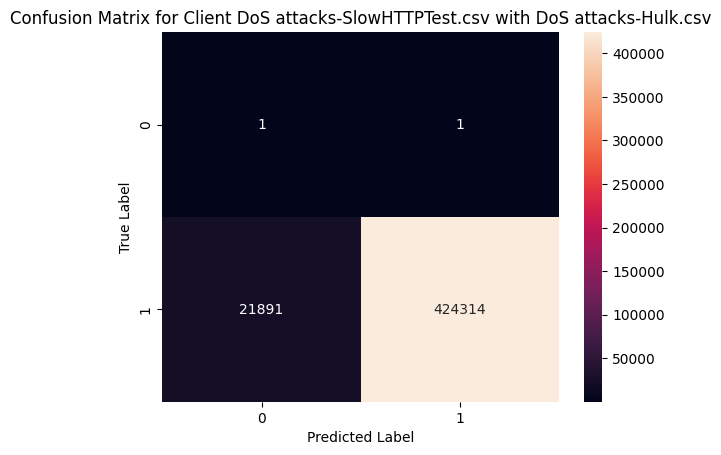

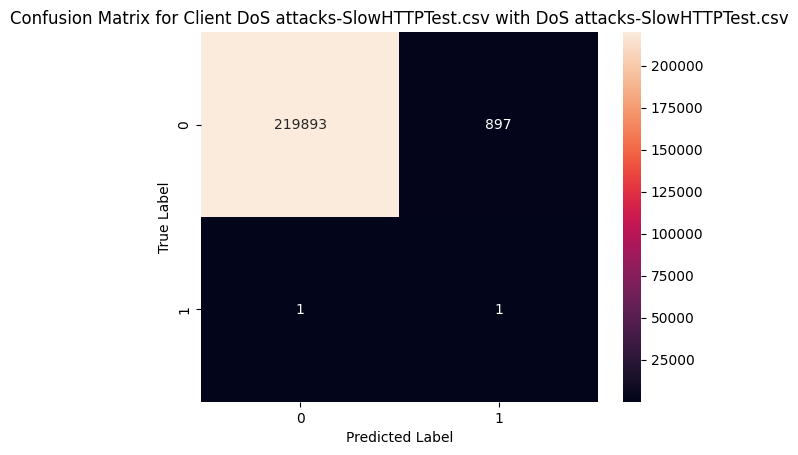

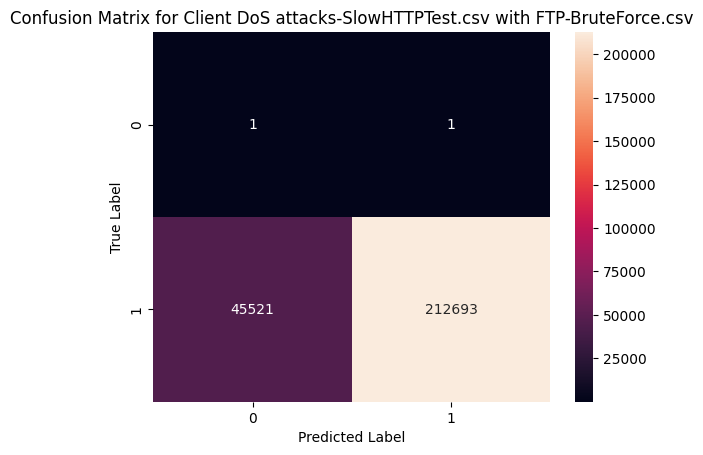

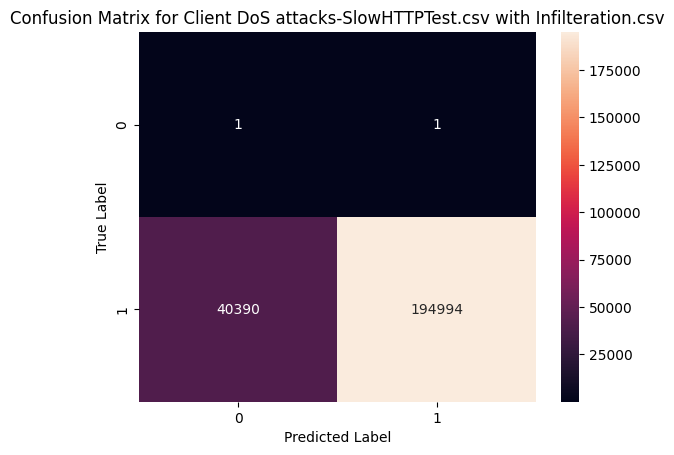

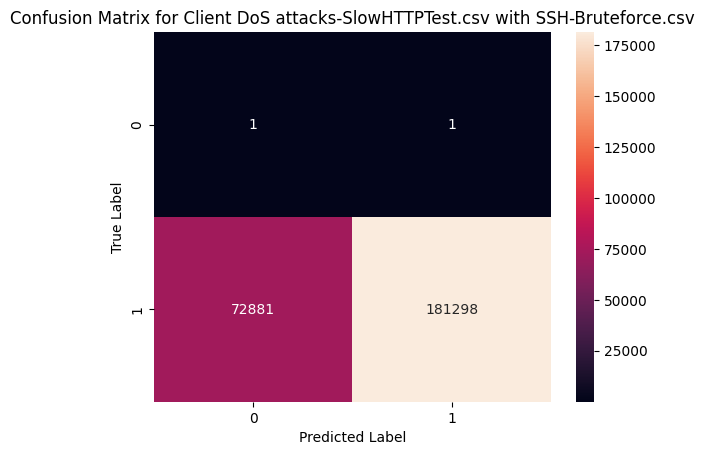

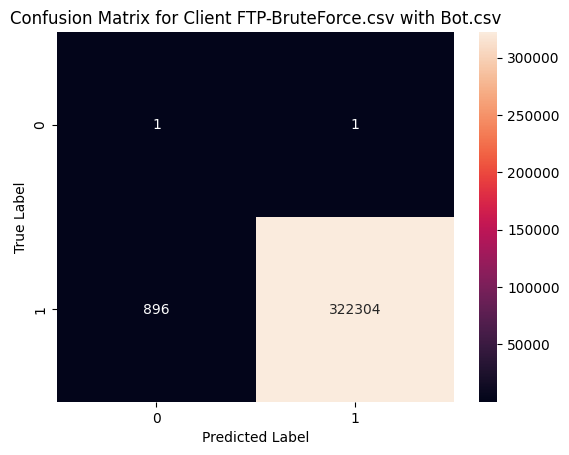

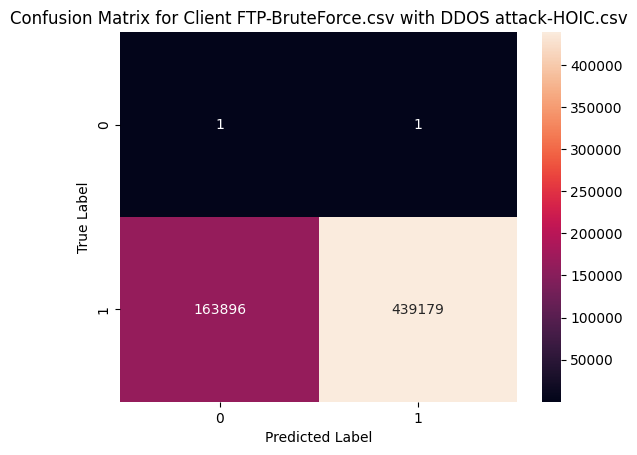

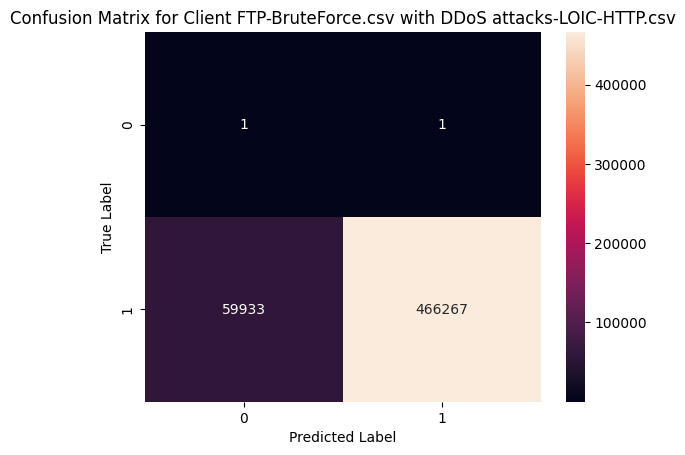

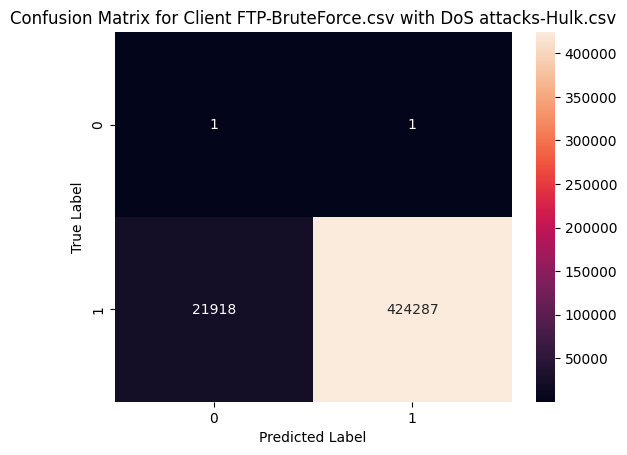

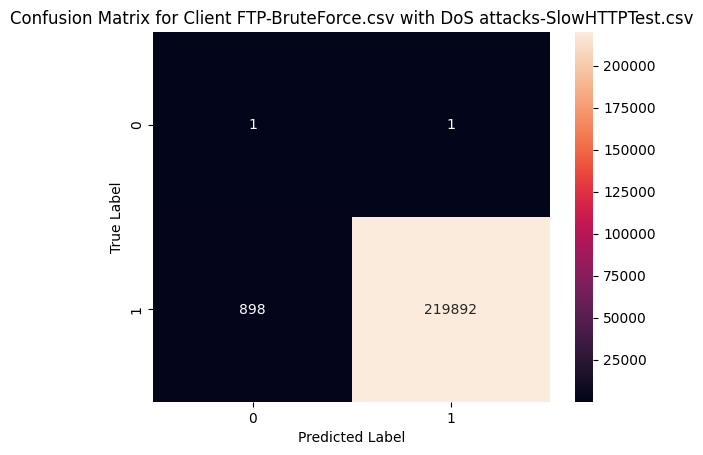

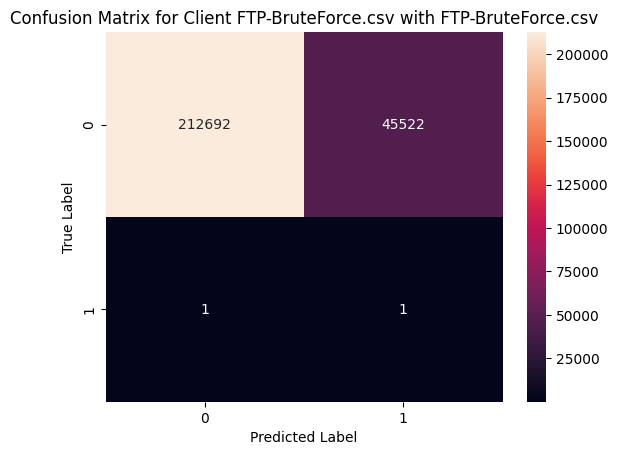

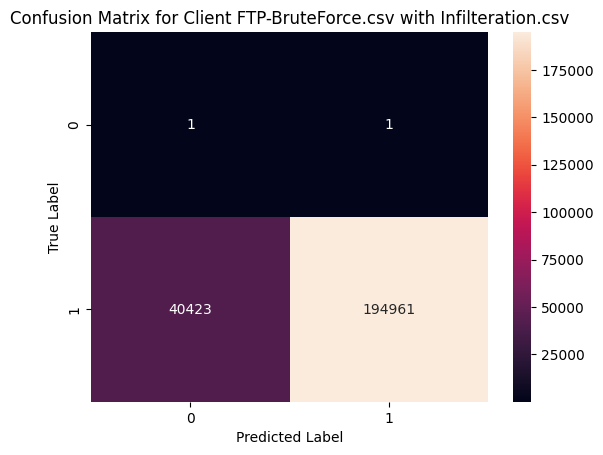

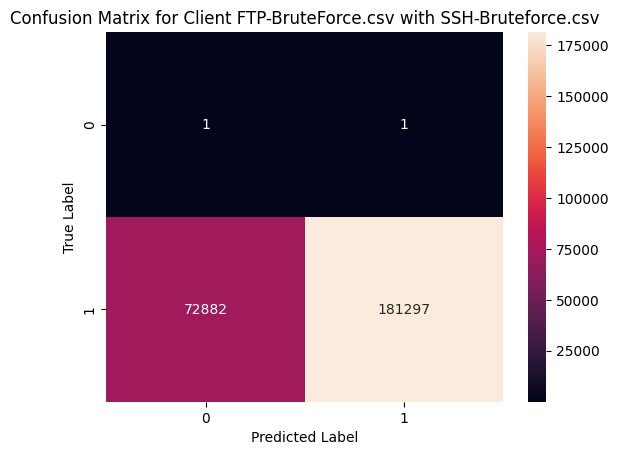

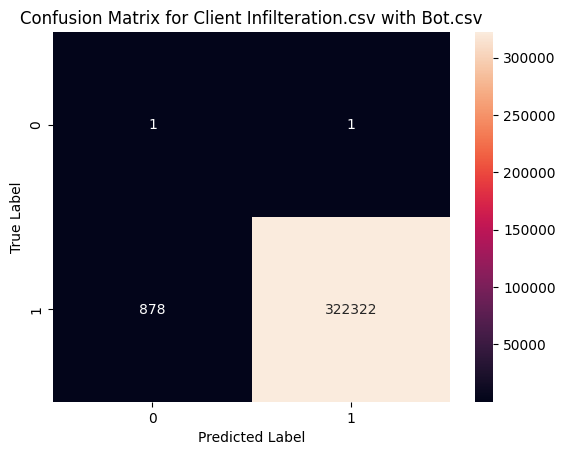

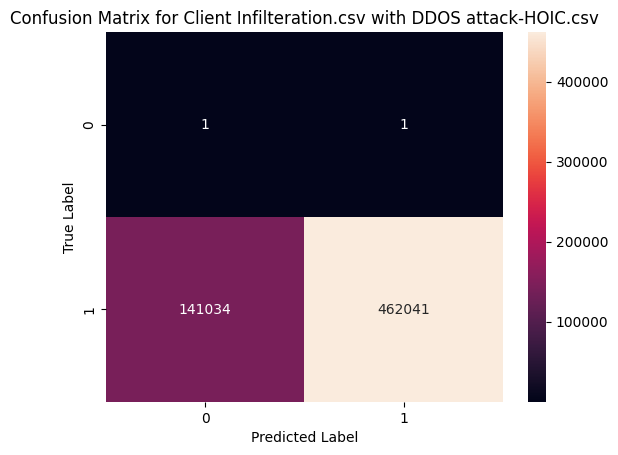

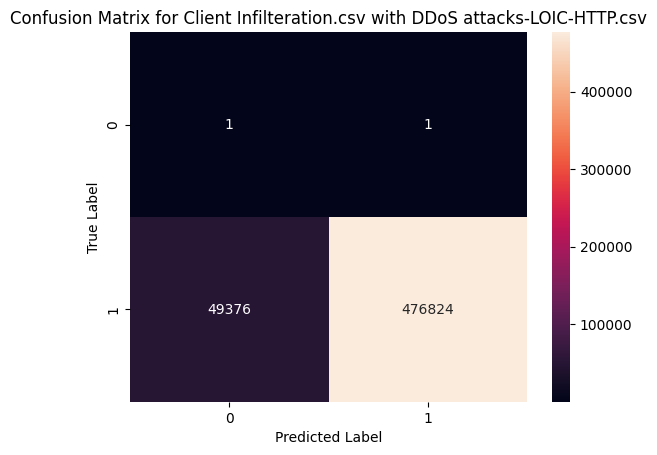

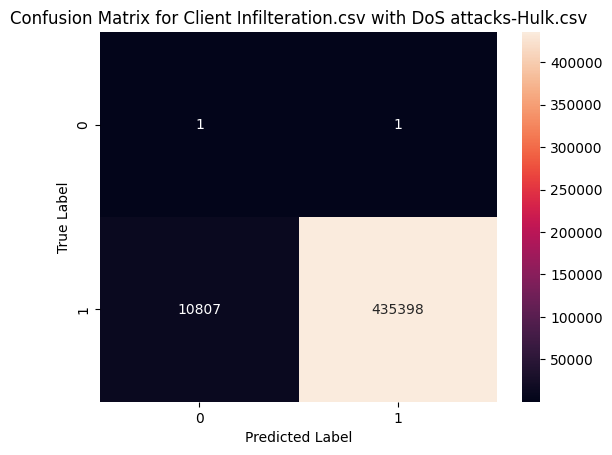

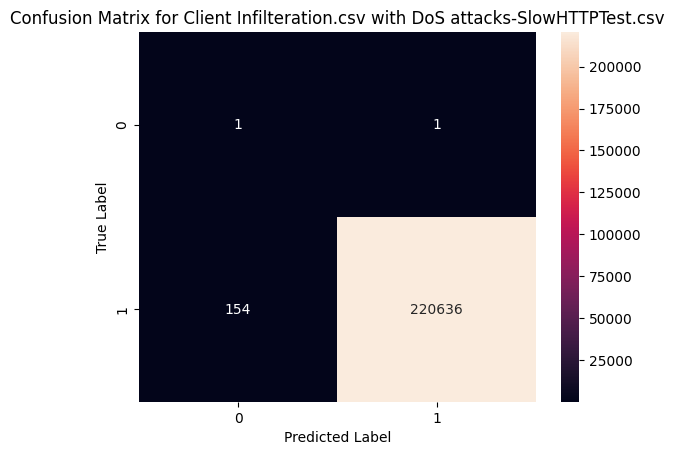

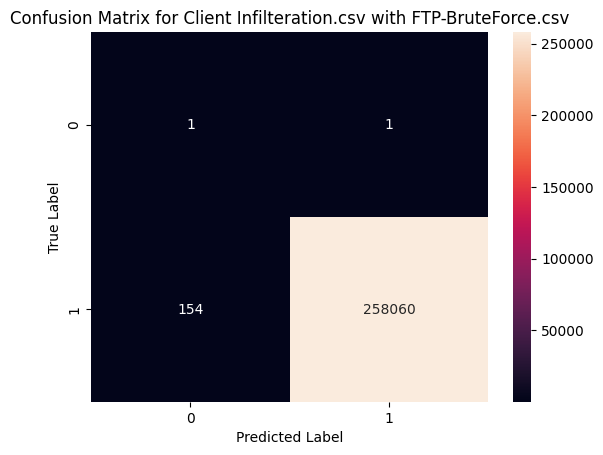

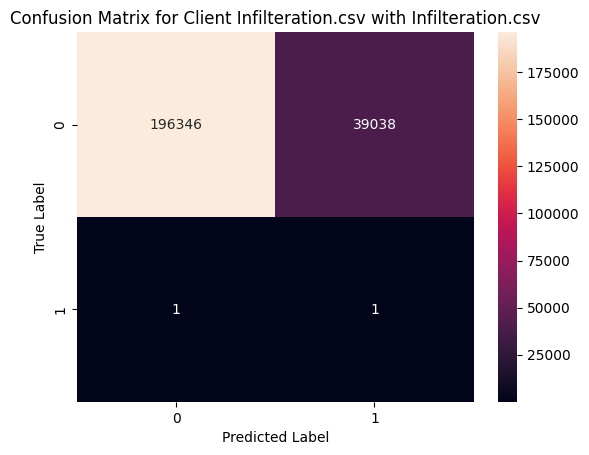

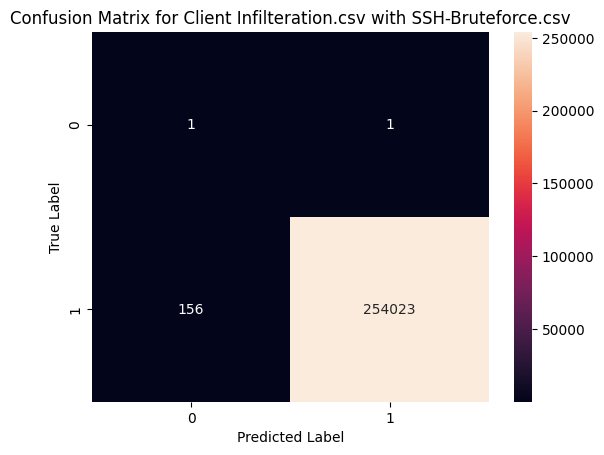

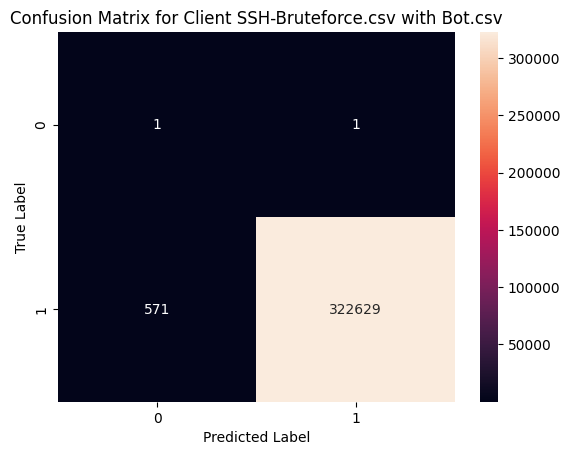

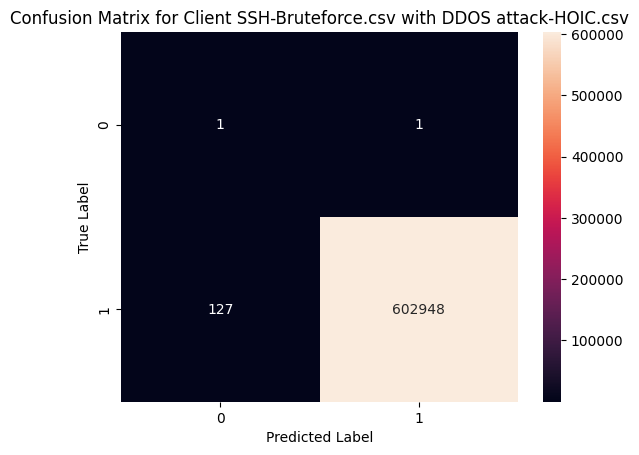

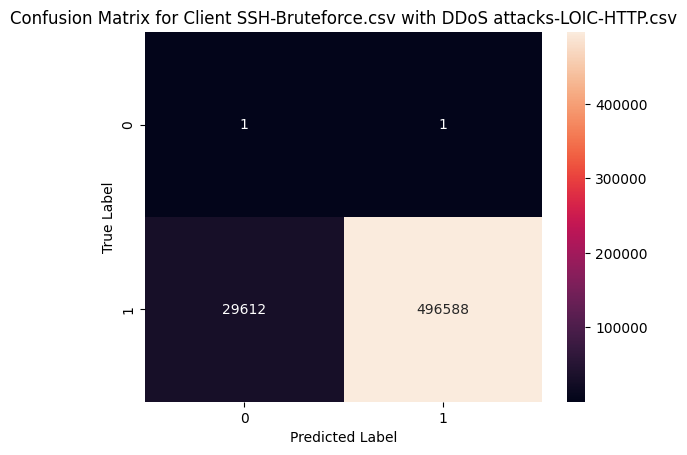

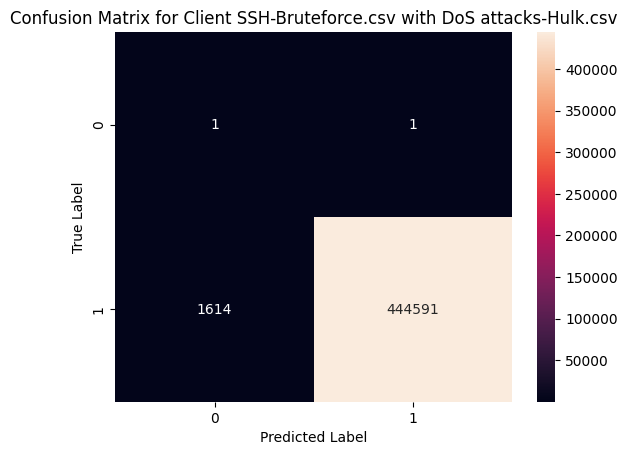

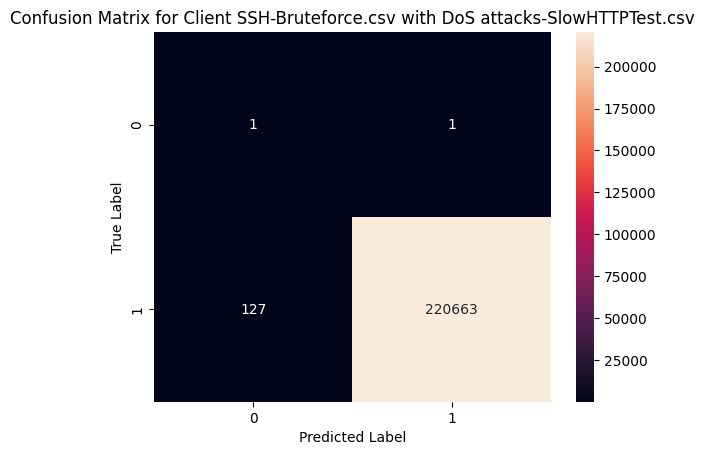

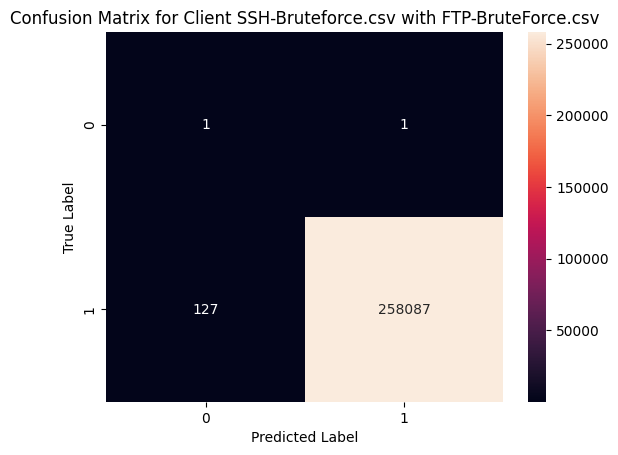

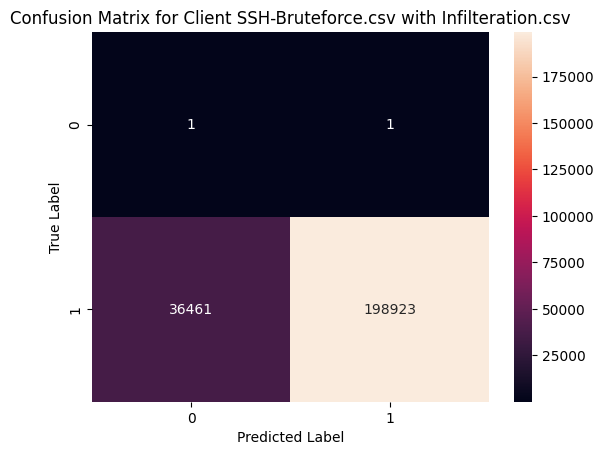

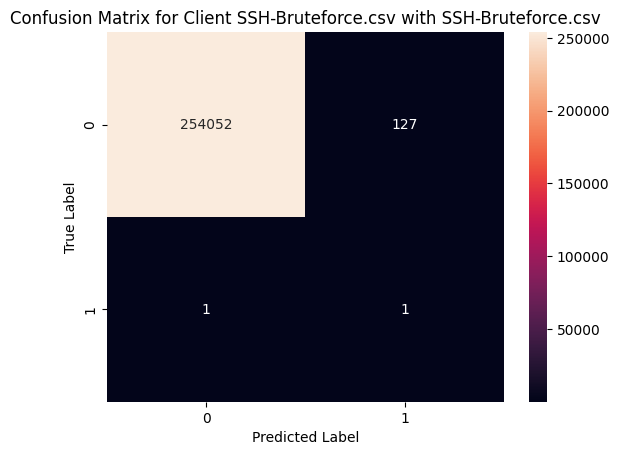

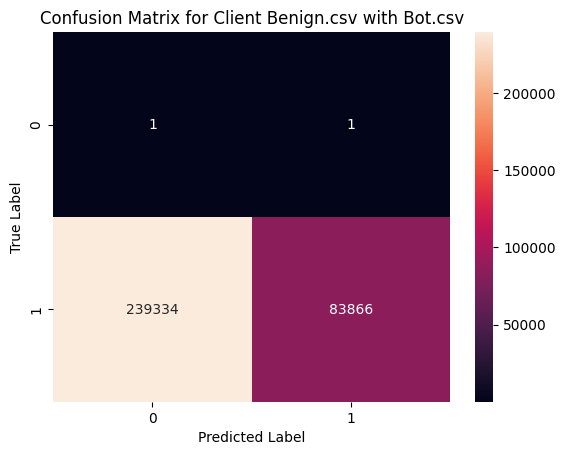

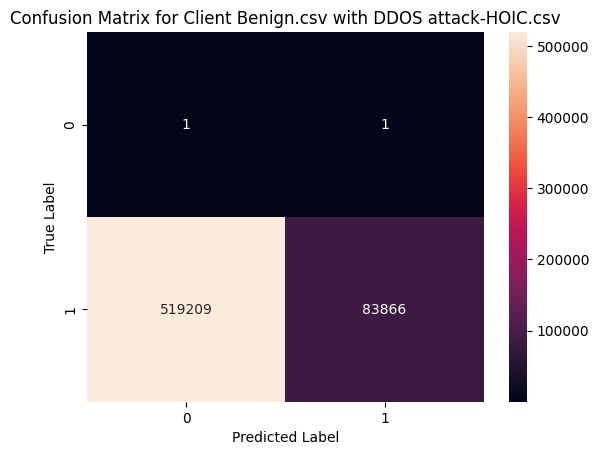

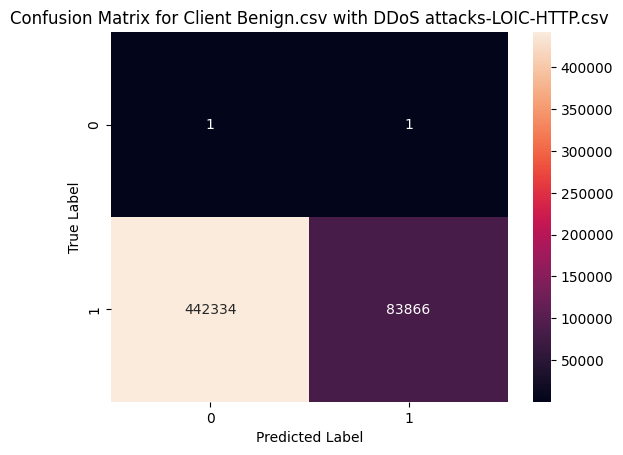

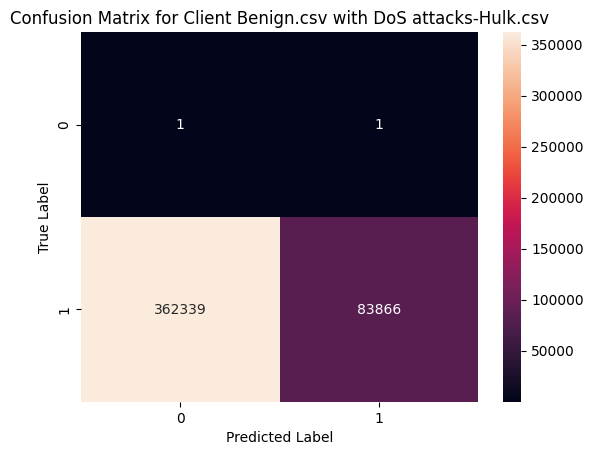

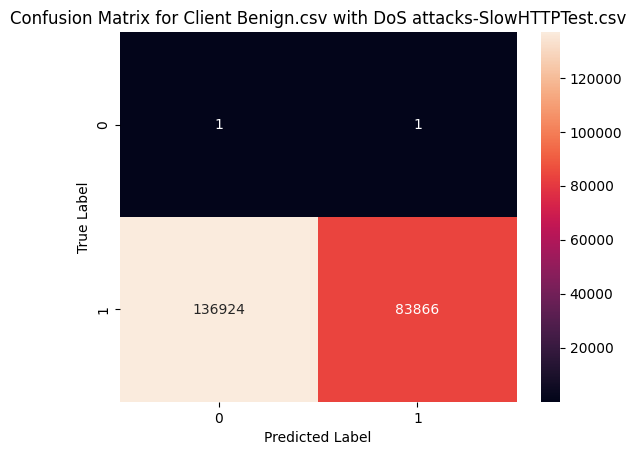

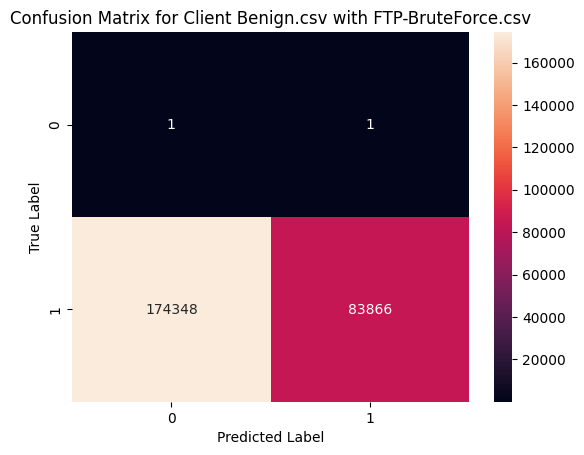

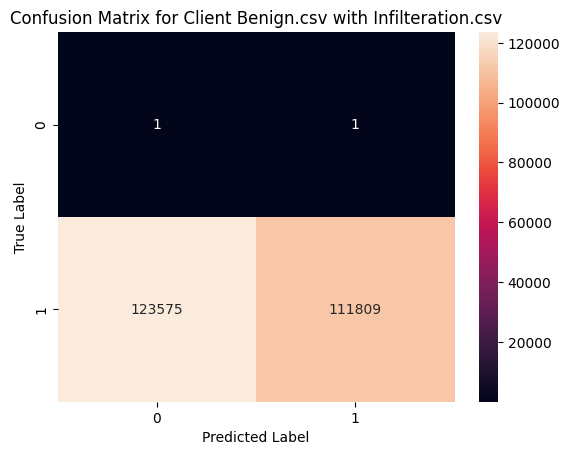

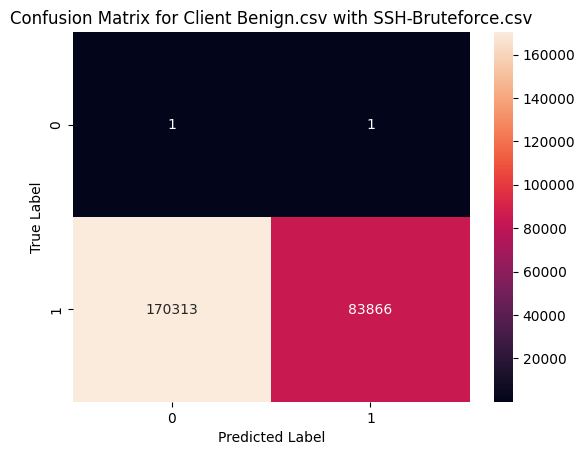

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
matrices=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  for i in attbenmixdata_loader:
    test_set = attbenmixdata_loader[i]
    labels = list(attbenmixdatalabels[i])
    y_true = []
    y_pred = []
    for batch in test_set:
      for data in batch:
        pred = model(data.float())
        error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
        if device == i:
          y_true.append(1)
          y_pred.append(1 if error <= threshold else 0)
        else:
          y_true.append(0)
          y_pred.append(0 if error <= threshold else 1)
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    matrices.append([str("Stats for Client " + str(device) +" with "+ str(i)),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [64]:
for i in matrices:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Bot.csv with Bot.csv
Accuracy: 99.72246458870923
Precision: 0.9999968973487845
Recall: 0.9972277227722772
F1 score : 99.861039031456
TPR : 0.997228
FPR : 0.5
Title: Stats for Client Bot.csv with DDOS attack-HOIC.csv
Accuracy: 72.82320499704018
Precision: 6.1013929480100305e-06
Recall: 0.5
F1 score : 0.0012202636989853508
TPR : 0.5
FPR : 0.271767
Title: Stats for Client Bot.csv with DDoS attacks-LOIC-HTTP.csv
Accuracy: 88.66765994808078
Precision: 1.6769800942462813e-05
Recall: 0.5
F1 score : 0.0033538477017758623
TPR : 0.5
FPR : 0.113322
Title: Stats for Client Bot.csv with DoS attacks-Hulk.csv
Accuracy: 95.08837826389994
Precision: 4.5628764373060775e-05
Recall: 0.5
F1 score : 0.009124920156948626
TPR : 0.5
FPR : 0.049114
Title: Stats for Client Bot.csv with DoS attacks-SlowHTTPTest.csv
Accuracy: 99.5928294503424
Precision: 0.0011123470522803114
Recall: 0.5
F1 score : 0.2219755826859045
TPR : 0.5
FPR : 0.004067
Title: Stats for Client Bot.csv with FTP-BruteForc

Plot for global model

In [66]:
# load model
global_model = torch.load('C:/Final Year Project/models/globalattackmodel.pt')                                        

# Testing client models with equal number of all data (selected and not selected)

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
selectedattackbenmix_stats = []
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  labels = list(selectedattackbenmix_labels)
  y_true = []
  y_pred = []
  test_set = selectedattackbenmix_loader
  ind = 0
  for batch in test_set:
    for data in batch:
      pred = model(data.float())
      error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
      if device == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if error <= threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error <= threshold else 1)
      ind += 1
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with "+ str(i)),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

C:\Users\amenu4aie20110\AppData\Local\Temp\ipykernel_16984\3129710148.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


In [ ]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
notselectedattackbenmix_stats = []
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  threshold = thresholds[device]
  labels = list(notselectedattackbenmix_labels)
  y_true = []
  y_pred = []
  test_set = notselectedattackbenmix_loader
  ind = 0
  for batch in test_set:
    for data in batch:
      pred = model(data.float())
      error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
      if device == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if error <= threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error <= threshold else 1)
      ind += 1
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    notselectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with "+ str(i)),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in notselectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

# Testing global model with equal number of all data (selected and not selected)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
selectedattackbenmix_stats_global = []
device_idx = {device: i for i, device in enumerate(devices)}
model = global_model
threshold = thresholds[device]
test_set = selectedattackbenmix_loader
labels = list(selectedattackbenmix_labels)
y_true = []
y_pred = []
ind = 0
for batch in test_set:
    for data in batch:
        pred = model(data.float())
        error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
        if device == labels[ind]:
            y_true.append(1)
            y_pred.append(1 if error <= thresholds[labels[ind]] else 0)
        else:
            y_true.append(0)
            y_pred.append(0 if error <= thresholds[labels[ind]] else 1)
        ind += 1
TP, FP, TN, FN = perf_measure(y_true, y_pred)
TP += 1
FN += 1
TN += 1
FP += 1
conf_matrix = [[TP, FN], [FP, TN]]
plt.figure() 
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP+FN)), 6)
# print('TPR is: {}%'.format(TPR))

FPR = round((FP / (FP + TN)), 6)
# print('TPR is: {}%'.format(FPR))

selectedattackbenmix_stats_global.append([str("Stats for Globel Model with "+ str(i)), acc*100, precision, recall, F1score*100, TPR, FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in selectedattackbenmix_stats_global:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
notselectedattackbenmix_stats_global = []
device_idx = {device: i for i, device in enumerate(devices)}
model = global_model
threshold = thresholds[device]
test_set = notselectedattackbenmix_loader
labels = list(notselectedattackbenmix_labels)
y_true = []
y_pred = []
ind = 0
for batch in test_set:
    for data in batch:
        pred = model(data.float())
        error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
        if device == labels[ind]:
            y_true.append(1)
            y_pred.append(1 if error <= thresholds[labels[ind]] else 0)
        else:
            y_true.append(0)
            y_pred.append(0 if error <= thresholds[labels[ind]] else 1)
        ind += 1
TP, FP, TN, FN = perf_measure(y_true, y_pred)
TP += 1
FN += 1
TN += 1
FP += 1
conf_matrix = [[TP, FN], [FP, TN]]
plt.figure() 
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP+FN)), 6)
# print('TPR is: {}%'.format(TPR))

FPR = round((FP / (FP + TN)), 6)
# print('TPR is: {}%'.format(FPR))

notselectedattackbenmix_stats_global.append([str("Stats for Globel Model with "+ str(i)), acc*100, precision, recall, F1score*100, TPR, FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in notselectedattackbenmix_stats_global:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))